In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
import deepinv as dinv
from tqdm import tqdm
import ProxNest as pxn
from ProxNest.sampling import resampling




## Initialisation

In [2]:
# Load Image
dim = 256
x_true = np.load('../../data/butterfly_{}.npy'.format(dim))

# Normalise magnitude
x_true -= np.nanmin(x_true)
x_true /= np.nanmax(x_true)
x_true[x_true<0] = 0

# To pytorch
x_true = torch.Tensor(x_true).to(device)
x = x_true.clone().to(device)

In [3]:
# Define noise parameters
ISNR = 20
sigma = np.sqrt(np.mean(np.abs(x_true.cpu().numpy())**2)) * 10**(-ISNR/20)

print('sigma*255: ', sigma*255)
# Define the forward operator
blur_kernel_size = 5

physics = dinv.physics.BlurFFT(
    img_size=(3, x.shape[-2], x.shape[-1]),
    filter=torch.ones(
        (1, 1, blur_kernel_size, blur_kernel_size),
        device=device
    ) / blur_kernel_size**2,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=sigma),
)

cpu_physics = dinv.physics.BlurFFT(
    img_size=(3, x.shape[-2], x.shape[-1]),
    filter=torch.ones(
        (1, 1, blur_kernel_size, blur_kernel_size),
        device='cpu'
    ) / blur_kernel_size**2,
    device='cpu',
    noise_model=dinv.physics.GaussianNoise(sigma=sigma),
)


# Compute observations
y = physics(x)


sigma*255:  13.653015464544296


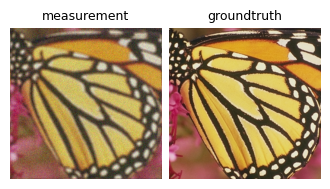

In [4]:
# Plot observations and true x

imgs = [y, x_true]
titles=["measurement", "groundtruth"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)

In [5]:
# Options dictionary associated with the overall sampling algorithm
options = {
    'samplesL': 1e1,        # Number of live samples
    'samplesD': 2e1,      # Number of discarded samples 
       'sigma': sigma,      # Noise standard deviation of degraded image
        'tol' : 1e-6,      # Convergence tolerance of algorithm (Ball projection alg)
   'max_iter' : 200,        # Maximum number of iterations (Ball projection alg)
    'verbose' : True,       # Verbosity
}

diff_params = {
         'model_type' : 'imagenet',     # Type of pretrained model. Options are 'imagenet' or 'ffhq'
        'in_channels' : 3,              # Channels in the input Tensor.
       'out_channels' : 3,              # Channels in the output Tensor.
        'sigma_noise' : sigma,          # Noise standard deviation of degraded image
    'diffusion_steps' : 100,            # Maximum number of iterations of the DiffPIR algorithm
            'lambda_' : 7.0,            # Regularisation parameter
               'zeta' : 0.5,            # DiffPIR parameter controling the diffusion
}


# Gaussian log likelihood
LogLikeliL = lambda x_current, y, physics, sigma : - torch.nn.functional.mse_loss(
    y,
    physics.A(x_current), # Apply the forward model (without the noise addition)
    reduction='sum'
) / (2*sigma**2)

LikeliL = LogLikeliL

# Load the denoiser for the diffusion model 
if diff_params['model_type'] == 'imagenet':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/256x256_diffusion_uncond.pt"
    large_model = True
elif diff_params['model_type'] == 'ffhq':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/diffusion_ffhq_10m.pt"
    large_model = False

denoising_model = dinv.models.DiffUNet(
    in_channels=diff_params['in_channels'],
    out_channels=diff_params['out_channels'],
    pretrained=model_path,
    large_model=large_model
).to(device)


In [6]:
class DummyDataFidelity(torch.nn.Module):
    def __init__(self):
        a = 1

    def prox(self, x, y=None, physics=None, gamma=None):
        return x


In [7]:
# Set initial state as current state
x_init = physics.A_adjoint(y)
Xcur = x_init
tau_0 = -LogLikeliL(Xcur, y, physics, sigma).cpu().numpy()  # * 1e-1



In [8]:

# Initialise arrays to store samples
# Indexing: sample, likelihood, weights
NumLiveSetSamples = int(options["samplesL"])
NumDiscardSamples = int(options["samplesD"])

# Placeholder for Bayesian evidence
BayEvi = np.zeros(2)

Xtrace = {}

# torch images are (1 x C x H x W)
Xtrace["LiveSet"] = torch.zeros(
    (NumLiveSetSamples, 1, Xcur.shape[1], Xcur.shape[2], Xcur.shape[3]), # Batch x 1 x Channels x Heigth x Width
    dtype=Xcur.dtype,
    device=device,
    requires_grad=False
)
Xtrace["LiveSetL"] = np.zeros(NumLiveSetSamples)

Xtrace["Discard"] = torch.zeros(
    (NumDiscardSamples, 1, Xcur.shape[1], Xcur.shape[2], Xcur.shape[3]), # Batch x 1 x Channels x Heigth x Width
    dtype=Xcur.dtype,
    device=device,
    requires_grad=False
)
Xtrace["DiscardL"] = np.zeros(NumDiscardSamples)
Xtrace["DiscardW"] = np.zeros(NumDiscardSamples)
Xtrace["DiscardPostProb"] = np.zeros(NumDiscardSamples)

# Build prior sampler
prior_sampler = dinv.sampling.DiffPIR(
    denoising_model,
    sigma=diff_params['sigma_noise'],
    max_iter=diff_params['diffusion_steps'],
    lambda_=diff_params['lambda_'],
    zeta=diff_params['zeta'], # 0.5,
    data_fidelity=DummyDataFidelity(),
    verbose=options['verbose'],
    device=device
)
# How to sample from the prior
# xhat =  prior_sampler.forward(y, physics, x_init)

# Build constrained prior sampler
constrained_prior_sampler = dinv.sampling.DiffPIR(
    denoising_model,
    sigma=diff_params['sigma_noise'],
    max_iter=diff_params['diffusion_steps'],
    lambda_=diff_params['lambda_'],
    zeta=diff_params['zeta'], # 0.5,
    data_fidelity=dinv.optim.data_fidelity.IndicatorL2(
        radius=(np.sqrt(
            tau_0 * 2 * diff_params['sigma_noise']**2
        ))
    ),
    verbose=options['verbose'],
    device=device
)



In [9]:

# Obtain samples from priors
for j in tqdm(range(NumLiveSetSamples), desc="DiffNest || Populate"):
    with torch.no_grad():
        # Sample from the prior to generate live samples
        Xcur = prior_sampler.forward(
            y, physics, x_init=x_init
        )
        # Record the current sample in the live set and its likelihood
        Xtrace["LiveSet"][j] = Xcur.clone()
        Xtrace["LiveSetL"][j] = LikeliL(
            Xcur.clone(), y, physics, diff_params['sigma_noise']
        ).detach().cpu().numpy()




DiffNest || Populate: 100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


In [15]:
LikeliL(
    x_init.clone(), y, physics, diff_params['sigma_noise']
).detach().cpu().numpy()

array(-169371.5, dtype=float32)

In [12]:
for it in range(len(Xtrace["LiveSetL"])):
    print(Xtrace["LiveSetL"][it])


-2449175.75
-2361680.5
-2878767.0
-2519603.25
-2474191.0
-2338624.5
-2518000.25
-2756292.5
-2292755.0
-2575931.0


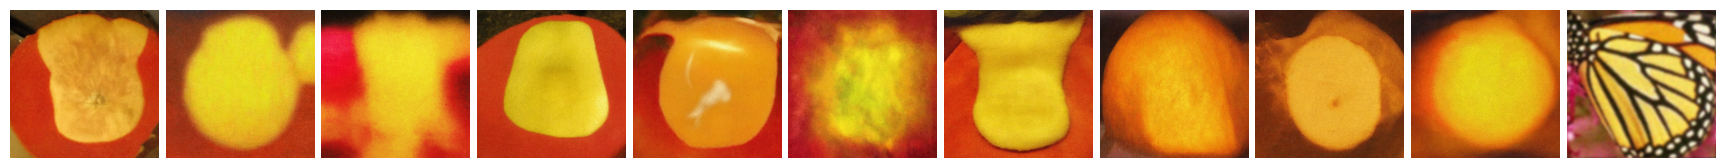

In [11]:


imgs = [_x for _x in Xtrace["LiveSet"]]
imgs.append(x_init)
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)



In [14]:

for it in range(len(Xtrace["LiveSetL"])):

    tau = - Xtrace["LiveSetL"][it]
    Xcur = Xtrace["LiveSet"][it].clone()

    if torch.nn.functional.mse_loss(
        y, physics.A(Xcur), reduction='sum'
    ) > (
        tau * 2 * diff_params['sigma_noise']**2
    ):
        print('Out of the ball sample: ', it)
        # print('Explicitly enforcing L2 ball in MH step.')
        # indicatorL2 = dinv.optim.data_fidelity.IndicatorL2(
        #     radius=np.sqrt(
        #         tau * 2 * diff_params['sigma_noise']**2
        #     ).astype(np.float32) 
        # )
        # Xcur = indicatorL2.prox(
        #     x=Xcur,
        #     y=y,
        #     physics=physics,
        #     crit_conv=options['tol'],
        #     max_iter=options['max_iter'],
        # )


Out of the ball sample:  3
Out of the ball sample:  4
Out of the ball sample:  9


In [28]:

print(np.linalg.norm((y-physics.A(Xcur)).cpu().squeeze().numpy())**2)

print(torch.nn.functional.mse_loss(y, physics.A(Xcur), reduction='sum'))

print(LogLikeliL(Xcur, y, physics, diff_params['sigma_noise']))


15646.371514909028
tensor(15646.3691, device='cuda:0')
tensor(-2729020.2500, device='cuda:0')


In [27]:
j = 1

tau = - Xtrace["LiveSetL"][j]
Xcur = Xtrace["LiveSet"][j].clone()



if torch.nn.functional.mse_loss(
    y, physics.A(Xcur), reduction='sum'
) > (
    tau * 2 * diff_params['sigma_noise']**2
):
    print('Explicitly enforcing L2 ball in MH step.')
    print('L2 ball constraint: ', np.sqrt(tau * 2 * diff_params['sigma_noise']**2))
    print('L2 ball cur: ',np.sqrt(torch.nn.functional.mse_loss(y, physics.A(Xcur), reduction='sum').cpu().item()))




Explicitly enforcing L2 ball in MH step.
L2 ball constraint:  0.06697229409343579
L2 ball cur:  125.08544735749639


In [32]:

tau

-0.6769505739212036

In [51]:


indicatorL2 = dinv.optim.data_fidelity.IndicatorL2(
    radius=np.sqrt(
        tau * 2 * diff_params['sigma_noise']**2
    ).astype(np.float32) 
)
proj_Xcur_torch = indicatorL2.prox(
    x=Xcur.clone(),
    y=y,
    physics=physics,
    radius=np.sqrt(
        tau * 2 * diff_params['sigma_noise']**2
    ).astype(np.float32),
    crit_conv=1e-10,
    max_iter=1000,
)




In [52]:

if torch.nn.functional.mse_loss(
    y, physics.A(proj_Xcur_torch), reduction='sum'
) > (
    tau * 2 * diff_params['sigma_noise']**2
):
    print('Explicitly enforcing L2 ball in MH step.')
    print('L2 ball constraint: ', tau * 2 * diff_params['sigma_noise']**2)
    print('L2 ball cur: ',torch.nn.functional.mse_loss(y, physics.A(proj_Xcur_torch), reduction='sum').cpu().item())



Explicitly enforcing L2 ball in MH step.
L2 ball constraint:  0.0038811797774195894
L2 ball cur:  155.62490844726562


In [103]:
proj_Xcur_torch.max()

tensor(3.6910, device='cuda:0')

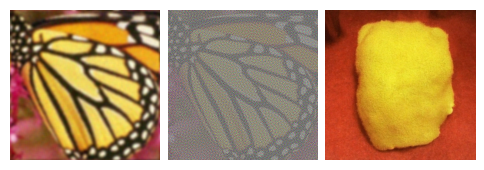

In [53]:

imgs = [x_init, proj_Xcur_torch, Xcur]
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)



# Try with ProxNest l2 projection

In [62]:

def sopt_fast_proj_B2(x, y, radius, forward_op, adj_forward_op, params):
    r"""Fast projection algorithm onto the :math:`\ell_2`-ball.

    Compute the projection onto the :math:`\ell_2` ball, i.e. solve

    .. math::

        z^* = \min_{z} ||x - z||_2^2   s.t.  ||y - \Phi z||_2 < \tau

    where :math:`x` is the input vector and the solution :math:`z^*` is returned as sol.

    Args:
        x (np.ndarray): A sample position :math:`x` in the posterior space.

        tau (float): Radius of likelihood :math:`\ell_2`-ball.

        params (dict): Dictionary of parameters defining the optimisation.

    Returns:
        np.ndarray: Optimal solution :math:`z^*` of proximal projection.

    Notes:
        [1] M.J. Fadili and J-L. Starck, "Monotone operator splitting for optimization problems in sparse recovery" , IEEE ICIP, Cairo, Egypt, 2009.

        [2] Amir Beck and Marc Teboulle, "A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems",  SIAM Journal on Imaging Sciences 2 (2009), no. 1, 183--202.
    """
    # Lambda function for scaling, used for tight frames only
    sc = lambda z: z * np.minimum(radius / np.linalg.norm(z), 1)

    # TIGHT FRAMES
    if (params["tight"]) and (params["pos"] or params["reality"]):

        temp = forward_op(x) - y
        sol = x + 1 / params["nu"] * adj_forward_op(sc(temp) - temp)
        crit_B2 = "TOL_EPS"
        iter = 0
        u = 0

    # NON-TIGHT FRAMES
    else:

        # Initializations
        sol = x
        # u = params['u']
        u = forward_op(sol)
        v = u
        iter = 1
        told = 1

        # Tolerance onto the L2 ball
        epsilon_low = radius / (1 + params["tol"])
        epsilon_up = radius / (1 - params["tol"])

        # Check if we are in the L2 ball
        dummy = forward_op(sol)
        norm_res = np.linalg.norm(y - dummy)
        if norm_res <= epsilon_up:
            crit_B2 = "TOL_EPS"
            true = 0

        # Projection onto the L2-ball
        if params["verbose"] > 1:
            print("  Proj. B2:")

        while 1:

            # Residual
            res = forward_op(sol) - y
            norm_res = np.linalg.norm(res)

            # Scaling for the projection
            res = u * params["nu"] + res
            norm_proj = np.linalg.norm(res)

            # Log
            if params["verbose"] > 1:
                print(
                    "   Iter {}, epsilon = {}, ||y - Phi(x)||_2 = {}".format(
                        iter, radius, norm_res
                    )
                )

            # Stopping criterion
            if (norm_res >= epsilon_low) and (norm_res <= epsilon_up):
                crit_B2 = "TOL_EPS"
                break
            elif iter >= params["max_iter"]:
                crit_B2 = "MAX_IT"
                break

            # Projection onto the L2 ball
            t = (1 + np.sqrt(1 + 4 * told**2)) / 2
            ratio = np.minimum(1, radius / norm_proj)
            u = v
            v = 1 / params["nu"] * (res - res * ratio)
            u = v + (told - 1) / t * (v - u)

            # Current estimate
            sol = x - adj_forward_op(u)

            # Projection onto the non-negative orthant (positivity constraint)
            if params["pos"]:
                sol = np.real(sol)
                sol[sol < 0] = 0

            # Projection onto the real orthant (reality constraint)
            if params["reality"]:
                sol = np.real(sol)

            # Increment iteration labels
            told = t
            iter = iter + 1

    # Log after the projection onto the L2-ball
    if params["verbose"] >= 1:
        temp = forward_op(sol)
        print(
            "  Proj. B2: epsilon = {}, ||y - Phi(x)||_2 = {}, {}, iter = {}".format(
                radius, np.linalg.norm(y - temp), crit_B2, iter
            )
        )

    return sol




In [89]:
sopt_params = {
    'verbose': 2,
    'tight': False,
    'tol': 1e-10,
    'max_iter': 200,
    'nu': 1.,
    'pos': True,
    'reality': True,
}

In [90]:

radius = np.sqrt(
    tau * 2 * diff_params['sigma_noise']**2
).astype(np.float32) 


forward_op = lambda x: cpu_physics.A(torch.from_numpy(x)).cpu().numpy()
adj_forward_op = lambda x: cpu_physics.A_adjoint(torch.from_numpy(x)).cpu().numpy()

Xcur = torch.clamp(Xcur, 0, 1)

proj_Xcur_sopt = sopt_fast_proj_B2(
    x=Xcur.cpu().numpy().copy(),
    y=y.cpu().numpy().copy(),
    radius=radius,
    forward_op=forward_op,
    adj_forward_op=adj_forward_op,
    params=sopt_params
)





  Proj. B2:
   Iter 1, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 116.29339599609375
   Iter 2, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 198.1586151123047
   Iter 3, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 54.673404693603516
   Iter 4, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 31.09063148498535
   Iter 5, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 23.950912475585938
   Iter 6, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 22.053274154663086
   Iter 7, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 21.48011589050293
   Iter 8, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 21.09369659423828
   Iter 9, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 20.756778717041016
   Iter 10, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 20.450162887573242
   Iter 11, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 20.169408798217773
   Iter 12, epsilon = 0.06229911372065544, ||y - Phi(x)||_2 = 19.911806106567383
   Iter 13, epsilon = 0.06229

In [99]:
if torch.nn.functional.mse_loss(
    y, physics.A(torch.tensor(proj_Xcur_sopt, device=device)), reduction='sum'
) > (
    tau * 2 * diff_params['sigma_noise']**2
):
    print('Explicitly enforcing L2 ball in MH step.')
    print('L2 ball constraint: ', tau * 2 * diff_params['sigma_noise']**2)
    print('L2 ball cur: ',torch.nn.functional.mse_loss(
        y, physics.A(torch.tensor(proj_Xcur_sopt, device=device)), reduction='sum'
    ).cpu().item())




Explicitly enforcing L2 ball in MH step.
L2 ball constraint:  0.0038811797774195894
L2 ball cur:  228.20547485351562


In [91]:
print(proj_Xcur_sopt.min())
print(proj_Xcur_sopt.max())


0.0
5.3720875


In [95]:
x_init.max()

tensor(0.9347, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


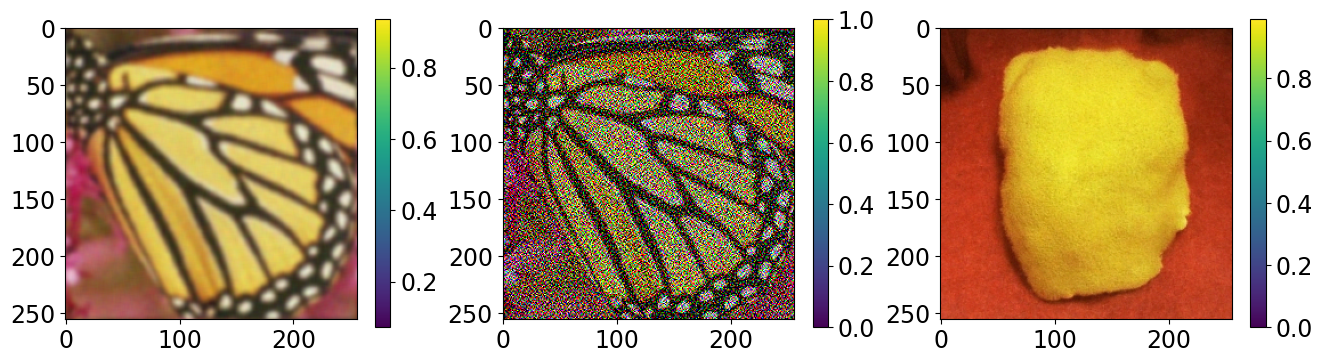

In [106]:


plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(np.moveaxis(x_init.cpu().squeeze().numpy(),0,2));plt.colorbar()
plt.subplot(132)
plt.imshow(np.moveaxis(np.squeeze(proj_Xcur_sopt,0),0,2));plt.colorbar()
plt.subplot(133)
plt.imshow(np.moveaxis(Xcur.cpu().squeeze().numpy(),0,2));plt.colorbar()
plt.show()


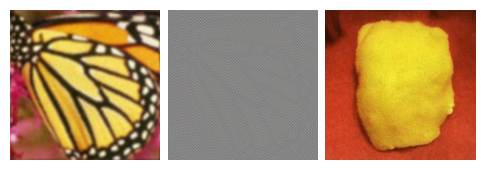

In [68]:

imgs = [x_init, torch.from_numpy(proj_Xcur_sopt), Xcur]
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)
